Written by Kristoffer Rakstad Solberg
Summer Intern, AKBM Transformation
2019

### Import libraries

In [1]:
"""
Written by Kristoffer Rakstad Solberg
Summer Intern, AKBM Transformation
2019
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from utils.load_catch_from_bigquery import load_BQ_and_clean

### Functions for filtering dataset

In [2]:
def filter_catch(df):
    
    # remove NULL rows
    df = df[df['Total catch Krill - Mt'].notnull()]
    df = df[df['Baric pressure (hPa)'].notnull()]
    df = df[df['Water temp (Celsius)'].notnull()]
    df = df[df['Krill Size (mm)'].notnull()]
    df = df[df['Wind speed (kn)'].notnull()]
    df = df[df['Krill weight (gram)'].notnull()]
    #df = df[df['FishingCondition'].notnull()]
        
    # FishingConditions with NULL is labelled as 'good fishing' if average catch is larger than 750mT
    df.loc[(df['FishingCondition'].isnull()) & (df['Total catch Krill - Mt'] > 750), ['FishingCondition']] = 'Good fishing' 
    df.loc[(df['FishingCondition'].isnull()) & (df['Total catch Krill - Mt'] < 751), ['FishingCondition']] = 'Bad fishing' 
    
    # Make fishing condition a binary value
    df.loc[df['FishingCondition'] == 'No fishing', ['FishingCondition']] = 'Bad fishing'
    conditions = pd.get_dummies(df['FishingCondition'], drop_first=True)
    df = pd.concat([df,conditions],axis=1)
    
    # 
    areas = pd.get_dummies(df['Area'], drop_first=False)
    df = pd.concat([df,areas],axis=1)
    
    # Drop unneccesary columns
    df = df.drop(columns=['Total Krill Meal Kg', 'Trawl depth (m)', 'TripNumber', 'Comments',
                          'Position','Vessel','Wind direction','ReasonForNoOrBadFishing'])

    
    return df

### Extract the dataframe

In [3]:
%%time
if __name__ == '__main__':
    # Get data
    df = load_BQ_and_clean()

Establishing connection to BigQuery in GCP.
    SUCCESS: Connection to BigQuery in GCP established.
Extracting catch data from 2010 to October 2018.
Extracting catch data from December 2018 onwards.
Merging and cleaning catch data
DONE after 10.87sec: Data extracted, merged and cleaned.
Wall time: 10.9 s


In [4]:
df.head()

,Vessel,Date,Total catch Krill - Mt,Total Krill Meal Kg,Position,Area,Trawl depth (m),Baric pressure (hPa),Water temp (Celsius),Krill Size (mm),Krill weight (gram),Comments,TripNumber,Wind direction,Wind speed (kn),FishingCondition,ReasonForNoOrBadFishing,Latitude,Longitude
0,Saga Sea,2010-01-14,356.15,35750.0,60°19 S 46°38 W,,NaN,NaN,NaN,43.3,0.69,,NaN,None,NaN,NaN,NaN,-60.316667,-46.633333
1,Saga Sea,2010-01-15,227.77,32250.0,60°24 S 46°38 W,,NaN,NaN,NaN,43.9,0.78,,NaN,None,NaN,NaN,NaN,-60.400000,-46.633333
2,Saga Sea,2010-01-16,439.06,58750.0,60°23 S 46°39 W,,NaN,NaN,NaN,43.4,0.75,,NaN,None,NaN,NaN,NaN,-60.383333,-46.650000
3,Saga Sea,2010-01-17,755.75,90000.0,60°25 S 46°40 W,,NaN,NaN,NaN,47.2,0.95,,NaN,None,NaN,NaN,NaN,-60.416667,-46.666667
4,Saga Sea,2010-01-18,406.26,62100.0,60°27 S 46°36 W,,NaN,NaN,NaN,41.8,0.55,,NaN,None,NaN,NaN,NaN,-60.450000,-46.600000


## Exploratory Data Analysis (EDA)

### Missing Data

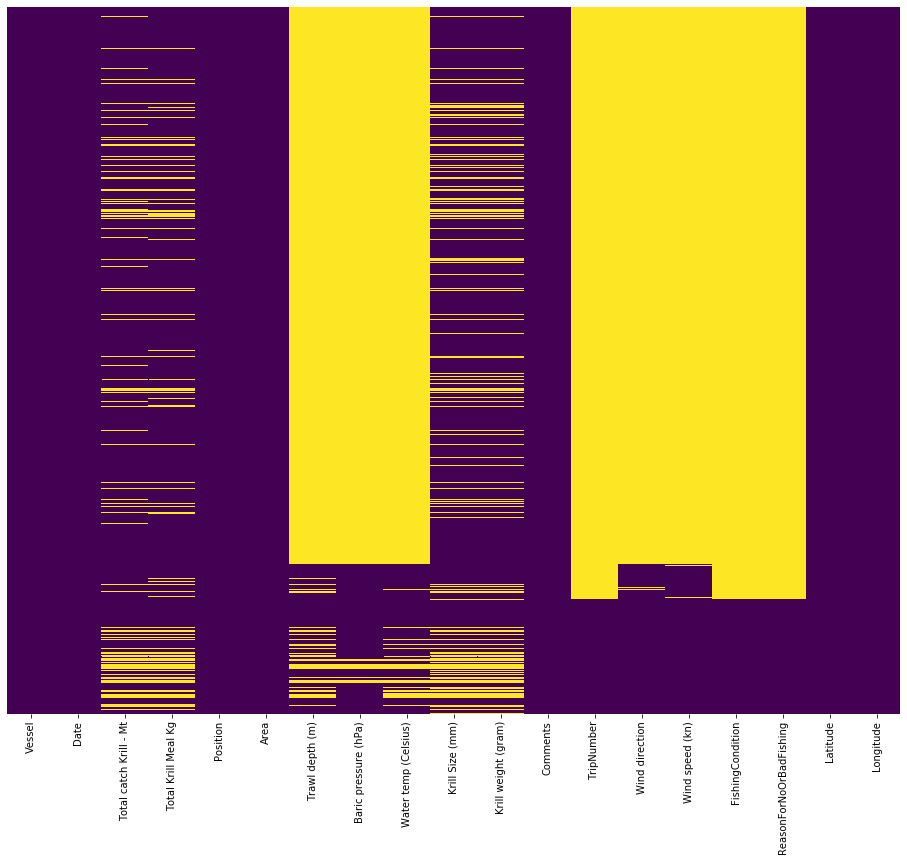

In [5]:
plt.figure(figsize=(16, 13))
ax = sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
figure = ax.get_figure()    
#figure.savefig('isNull.png')

### Filter Data

In [6]:
# remove bad rows
df_filtered = filter_catch(df)

# create month
df_filtered['month'] = df_filtered['Date'].dt.month
    
# re-index
df_filtered.index = pd.RangeIndex(len(df_filtered.index))

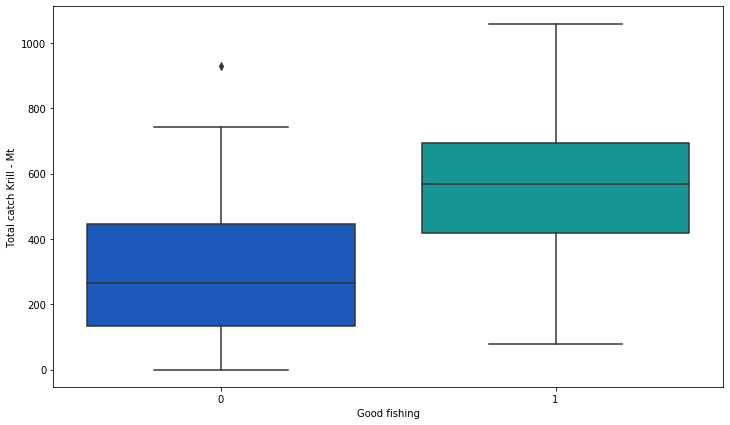

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Good fishing',y='Total catch Krill - Mt',data=df_filtered,palette='winter')
#plt.savefig('boxplot.eps')

In [8]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 16 columns):
Date                      599 non-null datetime64[ns]
Total catch Krill - Mt    599 non-null float64
Area                      599 non-null object
Baric pressure (hPa)      599 non-null float64
Water temp (Celsius)      599 non-null float64
Krill Size (mm)           599 non-null float64
Krill weight (gram)       599 non-null float64
Wind speed (kn)           599 non-null float64
FishingCondition          599 non-null object
Latitude                  599 non-null float64
Longitude                 599 non-null float64
Good fishing              599 non-null uint8
48.1                      599 non-null uint8
48.2                      599 non-null uint8
48.3                      599 non-null uint8
month                     599 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(1), object(2), uint8(4)
memory usage: 58.6+ KB


### Check data correlation

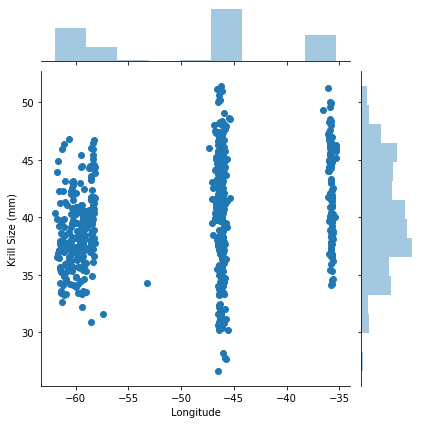

In [9]:
sns.jointplot(x='Longitude',y='Krill Size (mm)',data=df_filtered)

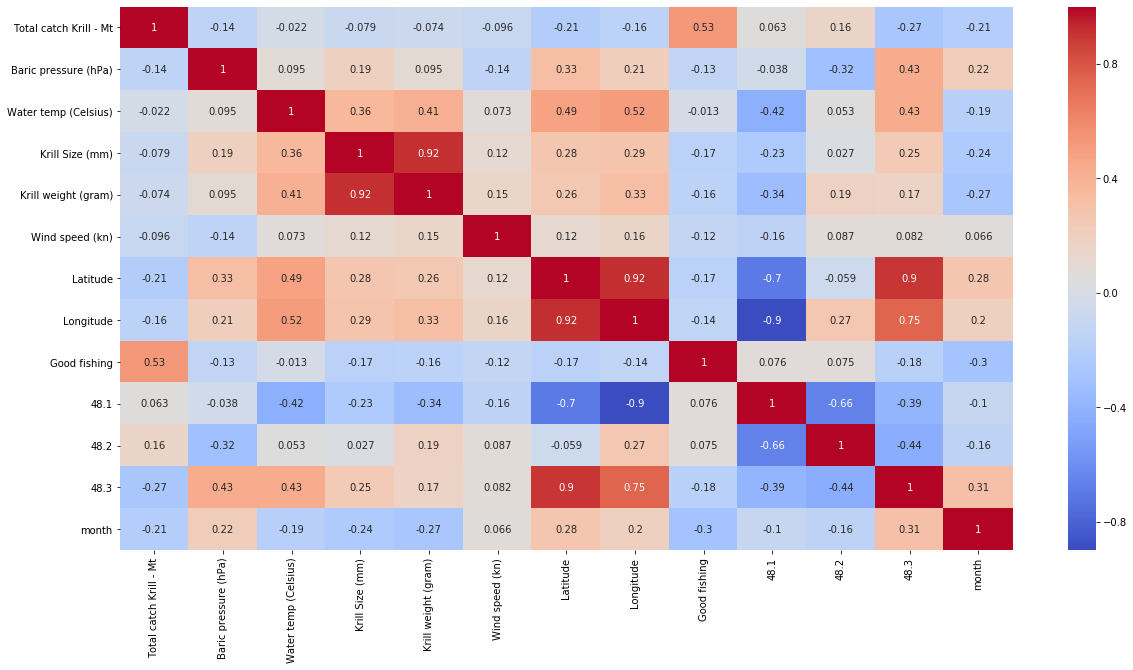

In [10]:
#sns.jointplot(x='Baric pressure (hPa)',y='Krill Size (mm)',data=df,kind='reg')
plt.figure(figsize = (20,10))
ax = sns.heatmap(df_filtered.corr(),cmap='coolwarm',annot=True)

## Training a Multiple Features Logistic Regression Model

To train the regression model, we will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case the Price column.

https://www.theaispace.com/blog/Polynomial-Regression

**Theory**

Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function (Sigmoid function):

$$ p(x) = \frac{1}{1 + e^{-(\theta_0 + \theta_1 x_1 + \theta_2 x_2)}} $$

$ p(x) $ is the probability that the dependent variable equals a case, given some linear combination of the predictors. 
$ \theta $ is the intercept from the linear regression equation (the value of the criterion when the predictor is equal to zero).
$ \theta x $ is the regression coefficient multiplied by some value of the predictor. 

Logistic regression can be binomial, ordinal or multinomial. Binomial or binary logistic regression deals with situations in which the observed outcome for a dependent variable can have only two possible types, "0" and "1" (which may represent, for example, "dead" vs. "alive" or "win" vs. "loss"). Multinomial logistic regression deals with situations where the outcome can have three or more possible types (e.g., "disease A" vs. "disease B" vs. "disease C") that are not ordered. Ordinal logistic regression deals with dependent variables that are ordered.

Source: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

### Choosing features

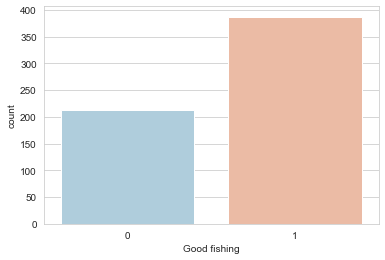

In [26]:
# Features
data = df_filtered[['Baric pressure (hPa)', 'Water temp (Celsius)','Wind speed (kn)','month', 'Longitude', 'Latitude', 'Good fishing']]
sns.set_style('whitegrid')
ax = sns.countplot(x='Good fishing',data=data,palette='RdBu_r')
#gure = ax.get_figure()    
f#gure.savefig('fishingCount.eps')

## Train Test Split
We have to split our dataset into a training part and a test part

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Good fishing',axis=1), 
                                                    data['Good fishing'], test_size=0.30, 
                                                    random_state=11)

In [14]:
X = data.drop('Good fishing',axis=1)
y = data['Good fishing']

# Splitting into test and training sets. Also applying stanardization to X as well.
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.30, random_state=11)

## Creating and Training the Model
Here we do the actual fitting in accordance to linear regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
# using regularization with C=1.0
# using optimization algorithm / solver 'lbfgs' rathan than gradient descent
logmodel = LogisticRegression(C=1.0, solver='lbfgs')
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Predictions from our Model 
We're now able to evaluate how well our Model is trained

In [17]:
predictions = logmodel.predict(X_test)

## Evaluation

**In general**

the four outcomes are called 

$ \textbf{True Positive}$ (you predict '1, Good fishing' and are correct)

$ \textbf{False Positive}$ (you predict '1, Good fishing' but are incorrect)

$ \textbf{True Negative}$ (you predict '0, Bad fishing' and are correct)

$ \textbf{False Negative}$ (you predict '0, Bad fishing' but are incorrect).

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36        70
           1       0.64      0.80      0.71       110

    accuracy                           0.60       180
   macro avg       0.56      0.54      0.53       180
weighted avg       0.57      0.60      0.57       180



**Precision** What proportion of positive identifications was actually correct?

$$ Precision = \frac{TP}{TP + FP} $$

- Our model has a precision of 0.81, meaning correct 81% of the time when predicting 'bad fishing'
- Our model has a precision of 0.81, meaning correct 81% of the time when predicting 'Good fishing'

**Recall** What proportion of actual positives was identified correctly?

$$ Recall = \frac{TP}{TP + FN} $$

- Our model has a recall of 0.51, meaning it correctly identifies 51% of 'bad fishing' spots
- Our model has a recall of 0.95, meaning it correctly identifies 95% of 'Good fishing' spots

### Scatter Plot

In [20]:
import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

In [21]:
# Add your own plotly user and mapbox access token
plotly.tools.set_credentials_file(username='sollimann', api_key='Mt0jyw4YVAEzihyWlLvL')
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')

mapbox_access_token = 'pk.eyJ1Ijoic29sbGltYW5uIiwiYSI6ImNqeDYyYWVkdDAwYXM0M3QyZ3AwNDJudWUifQ.NaYqXFLNEBG1cVzAdP-GYg'

In [22]:
def visualize_data(df,output_name):
    """
    INPUTS:
        
    
    OUTPUTS:
        
    """

    # data
    data = [
        go.Scattermapbox(
            lon = df['Longitude'],
            lat = df['Latitude'],
            text = df['Predictions'],
            mode='markers+text',
            marker=go.scattermapbox.Marker(
                size = 8, 
                opacity = 0.8,
                reversescale = False,
                autocolorscale = False,
                #colorscale = scl,
                #cmin = 0,#df['cluster'].min(),
                #color = df['cluster'],
                #cmax = df['cluster'].max(),
            ),
        )
    ]

    # Layout
    layout = go.Layout(
        title='catch sites',
        autosize=True,
        hovermode='closest',
        showlegend=True,
        mapbox=go.layout.Mapbox(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=-54,
                lon=-27
            ),
            pitch=0,
            zoom=2,
        ),
    )

    # Return figure
    fig = go.Figure(data=data,layout=layout)
    return fig

In [23]:
def display_prediction_in_text(df):
    
    #ground truth
    df.loc[df['Good fishing_y'] == 1, ['Good fishing_y']] = 'Good fishing'
    df.loc[df['Good fishing_y'] == 0, ['Good fishing_y']] = 'Bad fishing'
    
    # predictions
    df.loc[df['Predictions'] == 1, ['Predictions']] = 'Good fishing'
    df.loc[df['Predictions'] == 0, ['Predictions']] = 'Bad fishing'
    
    #re-label
    df['Ground truth'] = df['Good fishing_y']
    
    return df

In [24]:
#Compare test set VS predictions
y_test_df = pd.DataFrame(y_test)
y_test_df = pd.merge(y_test_df, df_filtered, left_index=True, right_index=True)
y_test_df = y_test_df.reset_index(drop=True)
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
results = pd.merge(y_test_df, predictions_df, left_index=True, right_index=True)
results = display_prediction_in_text(results)

# Drop unneccesary columns
results.drop(columns=['Good fishing_x','Good fishing_y', 'Date', 'Area','Baric pressure (hPa)','Krill Size (mm)',
                  'Water temp (Celsius)','Krill weight (gram)','Wind speed (kn)','FishingCondition',
                  '48.1','48.2','48.3'])

,Total catch Krill - Mt,Latitude,Longitude,month,Predictions,Ground truth
0,653.184000,-60.366667,-46.533333,3,Good fishing,Good fishing
1,71.791000,-53.966667,-35.766667,8,Bad fishing,Bad fishing
2,797.524000,-60.400000,-45.983333,2,Good fishing,Good fishing
3,736.770000,-63.200000,-58.183333,6,Good fishing,Bad fishing
4,574.276000,-53.933333,-35.766667,7,Good fishing,Good fishing
5,449.692000,-53.966667,-35.850000,7,Bad fishing,Good fishing
6,830.529479,-63.216667,-60.366667,6,Good fishing,Good fishing
7,474.996000,-60.433333,-46.250000,1,Good fishing,Bad fishing
8,494.140000,-35.933333,-35.766667,8,Bad fishing,Bad fishing
9,518.411000,-60.450000,-46.000000,3,Good fishing,Bad fishing


In [25]:
fig = visualize_data(results,'clustered_plot')
py.iplot(fig, filename='catch-sites')

C:\Users\ua388\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

